In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

physical_devices = tf.config.experimental.list_physical_devices('GPU')

### Data Preparation

In [11]:
import os
import random
import glob
import shutil

# Path where original 25,000 images are stored
source_dir = '/Users/utkarshchandra/Documents/train/'
# Destination base folder
dataset_dir = '/Users/utkarshchandra/Documents/dogs-vs-cats'

# Create folders: train/valid/test with cat and dog
for split in ['train', 'valid', 'test']:
    for category in ['cat', 'dog']:
        os.makedirs(os.path.join(dataset_dir, split, category), exist_ok=True)

# Change to source dir
os.chdir(source_dir)

# Load and shuffle images
cat_images = glob.glob('cat.*.jpg')
dog_images = glob.glob('dog.*.jpg')
random.shuffle(cat_images)
random.shuffle(dog_images)

print(f"Found {len(cat_images)} cat images and {len(dog_images)} dog images.")

# Counts
train_count = min(500, len(cat_images), len(dog_images))
valid_count = min(100, len(cat_images) - train_count, len(dog_images) - train_count)
test_count = min(50, len(cat_images) - train_count - valid_count, len(dog_images) - train_count - valid_count)

# Copy function
def copy_files(files, dest_dir):
    for f in files:
        shutil.copy(f, dest_dir)

# Copy cat images
copy_files(cat_images[:train_count], os.path.join(dataset_dir, 'train/cat'))
copy_files(cat_images[train_count:train_count+valid_count], os.path.join(dataset_dir, 'valid/cat'))
copy_files(cat_images[train_count+valid_count:train_count+valid_count+test_count], os.path.join(dataset_dir, 'test/cat'))

# Copy dog images
copy_files(dog_images[:train_count], os.path.join(dataset_dir, 'train/dog'))
copy_files(dog_images[train_count:train_count+valid_count], os.path.join(dataset_dir, 'valid/dog'))
copy_files(dog_images[train_count+valid_count:train_count+valid_count+test_count], os.path.join(dataset_dir, 'test/dog'))

print("✅ Dataset successfully copied into train/valid/test folders.")


Found 12500 cat images and 12500 dog images.
✅ Dataset successfully copied into train/valid/test folders.


In [12]:
train_path='/Users/utkarshchandra/Documents/dogs-vs-cats/train'
valid_path='/Users/utkarshchandra/Documents/dogs-vs-cats/valid'
test_path='/Users/utkarshchandra/Documents/dogs-vs-cats/test'

In [13]:


# VGG16 preprocessing function
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Image data generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

# Flow from directories
train_batches = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    classes=['cat', 'dog'],
    batch_size=10,
    shuffle=True
)

valid_batches = valid_datagen.flow_from_directory(
    directory=valid_path,
    target_size=(224, 224),
    classes=['cat', 'dog'],
    batch_size=10,
    shuffle=False
)

test_batches = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    classes=['cat', 'dog'],
    batch_size=10,
    shuffle=False
)


Found 1000 images belonging to 2 classes.


Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-120.68..139.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..111.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..147.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-109.68..121.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..140.061].
Clipping input data t

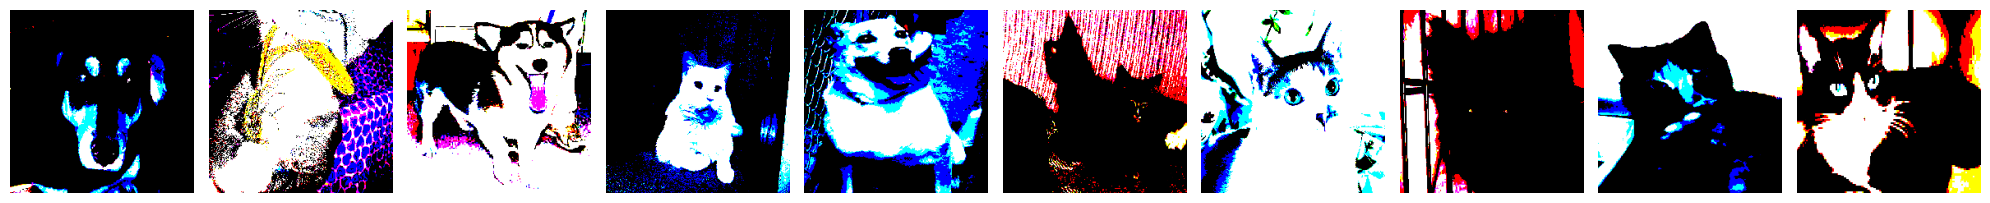

In [14]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

imgs, labels = next(train_batches)

# This function will plot images in the form of a grid with 1 row and 10 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)



## 🧠 **Theory Summary**

This code snippet performs **dataset validation and visualization** in a deep learning pipeline using Keras' `ImageDataGenerator`. It helps ensure your dataset is loaded correctly, has the expected number of images and classes, and displays a batch of sample images for manual inspection. This is a crucial step before training to catch any data loading or preprocessing issues.

---

## ✅ **Keypoints Summary**

### 🔹 **1. Dataset Assertions**

```python
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2
```

* Verifies dataset size:

  * 1000 training images
  * 200 validation images
  * 100 test images
* Ensures all splits have **2 classes** (`cat` and `dog`).

---

### 🔹 **2. Fetch a Batch**

```python
imgs, labels = next(train_batches)
```

* Retrieves the **next batch** (default 32 images and their labels) from the training generator.
* Useful for viewing sample input before training.

---

### 🔹 **3. Visualize Images**

```python
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
```

* Displays the **first 10 images** from the batch in a clean grid (1 row, 10 columns).
* Helps confirm:

  * Images are loaded and resized correctly (e.g., 224×224 for VGG16).
  * No distortion or blank images.
  * Preprocessing (like normalization) is applied properly.
  * Data augmentation (if used) is working.

---

## 📌 Why This is Important:

* Ensures data is correctly prepared before training.
* Prevents silent errors due to missing or wrongly labeled data.
* Gives you confidence in the data pipeline.

---


 ### Build and train a CNN 

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Build the CNN model
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')  # 2 output classes
])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)




## 🧠 **What is this model doing?**

It’s a **Convolutional Neural Network (CNN)** that:

* Takes **224×224 RGB images** of cats and dogs,
* Extracts features using filters,
* Reduces image size gradually using pooling,
* Finally classifies the image into **one of two categories**: **cat or dog**.

---

## ✅ **Layer-by-Layer Explanation**

```python
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3))
```

* **Conv2D**: Applies 32 filters (feature detectors), each of size 3×3.
* **filters=32**: Learns 32 different patterns (e.g., edges, textures).
* **kernel\_size=(3, 3)**: Each filter scans a 3×3 area at a time.
* **activation='relu'**: Keeps positive values, removes negatives → adds non-linearity.
* **padding='same'**: Keeps output size same as input (224×224).
* **input\_shape=(224, 224, 3)**: Input image is 224×224 pixels with 3 color channels (RGB).

---

```python
MaxPooling2D(pool_size=(2, 2), strides=2)
```

* **MaxPooling**: Reduces size of image features by taking the **max value** in a 2×2 block.
* **pool\_size=(2, 2)**: Looks at 2×2 areas and picks the largest value → reduces image size by **half**.

  * For example: 224×224 → 112×112
* **strides=2**: Moves 2 steps each time → no overlap, smooth downsampling.
* ❓ **Why (2, 2)?**

  * It's the most common because it reduces size cleanly.
  * You **can** use other sizes like (2, 3), but it may distort spatial patterns.
  * Try only if you have a specific reason.

---

```python
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')
```

* Similar to the first Conv2D, but now learns **64 more complex patterns** (since image features are more abstract now).

---

```python
MaxPooling2D(pool_size=(2, 2), strides=2)
```

* Again reduces size from 112×112 → 56×56 (approximately).

---

```python
Flatten()
```

* Converts the 3D output of the last pooling layer into a **1D vector**.
* Prepares the data for the fully connected layer.

---

```python
Dense(units=2, activation='softmax')
```

* Fully connected layer with **2 neurons** → one for cat, one for dog.
* **softmax**: Converts output into probabilities that sum to 1.

  * e.g., output: `[0.9, 0.1]` → class 0 (cat), 90% confidence.

---

## 🔍 What Happens If We Change Parameters?

| Parameter                        | Effect                                                    |
| -------------------------------- | --------------------------------------------------------- |
| `filters=32` → 64                | Learns more features, but uses more memory                |
| `kernel_size=(3, 3)` → (5, 5)    | Sees larger patterns but may miss small details           |
| `pool_size=(2, 2)` → (2, 3)      | Uneven reduction → might distort width/height ratio       |
| `strides=2` → 1                  | More overlap → slower but more detailed feature maps      |
| `padding='valid'`                | Output shrinks after convolution                          |
| `Dense(units=2)` → 1 + `sigmoid` | Use this for binary classification with one output neuron |

---



In [16]:

# Print model architecture
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │       401,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,802 (1.61 MB)

 Trainable params: 420,802 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [18]:

# Train the model
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 - 7s - 75ms/step - accuracy: 0.5530 - loss: 17.3317 - val_accuracy: 0.6050 - val_loss: 4.2543
Epoch 2/10
100/100 - 7s - 72ms/step - accuracy: 0.7810 - loss: 1.8390 - val_accuracy: 0.6650 - val_loss: 2.6598
Epoch 3/10
100/100 - 7s - 73ms/step - accuracy: 0.9280 - loss: 0.2692 - val_accuracy: 0.6850 - val_loss: 2.1424
Epoch 4/10
100/100 - 7s - 74ms/step - accuracy: 0.9730 - loss: 0.0670 - val_accuracy: 0.6850 - val_loss: 1.6599
Epoch 5/10
100/100 - 8s - 75ms/step - accuracy: 0.9990 - loss: 0.0071 - val_accuracy: 0.6900 - val_loss: 1.7118
Epoch 6/10
100/100 - 8s - 76ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.6900 - val_loss: 1.6807
Epoch 7/10
100/100 - 8s - 76ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.6750 - val_loss: 1.6577
Epoch 8/10
100/100 - 8s - 77ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.6750 - val_loss: 1.6675
Epoch 9/10
100/100 - 8s - 78ms/step - accuracy: 1.0000 - loss: 9.0167e-04 - val_accuracy: 0.6900 - val_loss: 1.683

### ✅ Summary: Model Performance Analysis

From the training logs, we can summarize the model's behavior and **diagnose whether it is well-trained, underfit, or overfit**.

---

### 📊 **Training & Validation Summary**

| Metric                  | Observation                                                     |
| ----------------------- | --------------------------------------------------------------- |
| **Train Accuracy**      | Increases from **58.9% → 100%** over 10 epochs                  |
| **Train Loss**          | Drops from **20.38 → near zero (0.0003)**                       |
| **Validation Accuracy** | Stuck around **57%–65%**, does not improve much                 |
| **Validation Loss**     | Remains high around **2.2–6.1** and doesn't reduce consistently |

---

### ❌ **Conclusion: The Model is Overfitting**

---

### 🔍 **How Do We Know It’s Overfitting?**

| Sign                                     | Evidence                                           |
| ---------------------------------------- | -------------------------------------------------- |
| 🔺 Very high training accuracy           | Reaches **100%** by epoch 8                        |
| 🔻 Low and stagnant validation accuracy  | Stuck at **\~60–65%**, not improving significantly |
| 🔺 Very low training loss                | Almost **zero** — indicates memorization           |
| 🔻 High and inconsistent validation loss | Around **2.2 to 6.1** — shows poor generalization  |

---

### 💡 What Is Overfitting?

* Overfitting means the model performs **very well on training data** but **poorly on unseen data** (validation/test).
* It has **memorized** the training set instead of **learning general patterns**.

---

### 🛠️ How to Fix Overfitting

1. **Add Dropout Layers**:

   * Introduce `Dropout(0.5)` after dense or conv layers to prevent memorization.

2. **Use Data Augmentation**:

   * Apply `ImageDataGenerator` with rotation, flips, zoom, etc., to expose model to more variation.

3. **Reduce Model Complexity**:

   * Reduce number of filters or layers if the dataset is small.

4. **Early Stopping**:

   * Stop training when validation loss stops improving.

5. **More Data**:

   * Get more labeled training images if possible.

---




### **Predict**


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-113.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..134.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-119.68..101.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data 

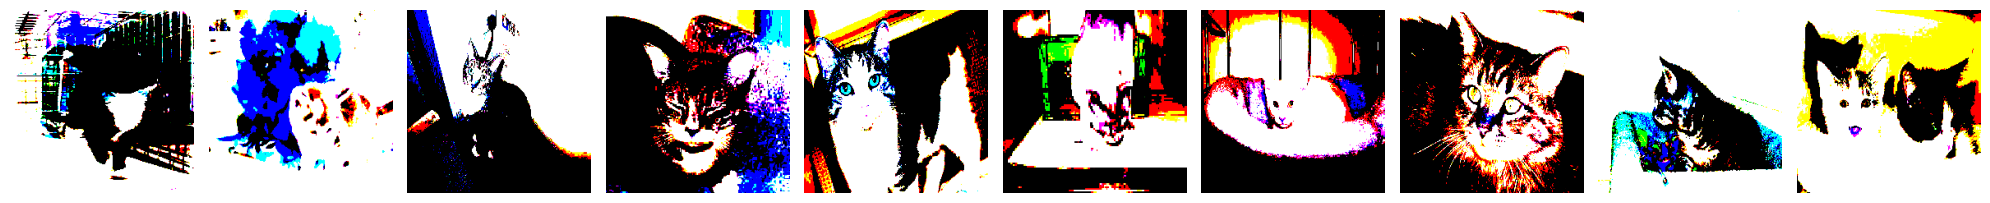

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [19]:
test_imgs, test_labels =next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [20]:
test_batches.classes


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [21]:
predictions = model.predict(x = test_batches, verbose=0)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [22]:
np.round(predictions)

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.

In [23]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=-1))

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[34 16]
 [19 31]]


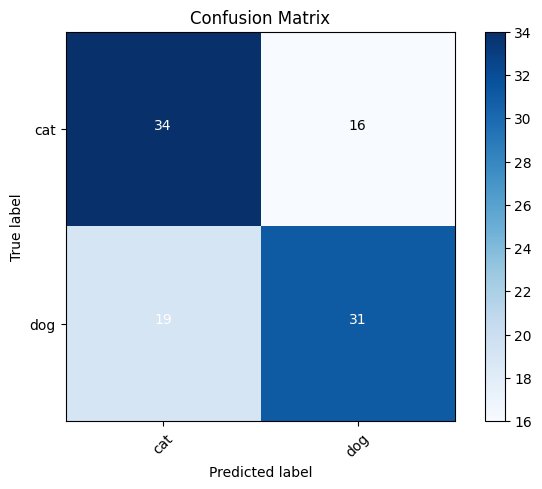

In [26]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, classes=cm_plot_labels, title='Confusion Matrix')